# Prevendo Customer Churn em Operadoras de Telecom

Métricas e indicadores são comuns em empresas, com quantos novos planos foram vendidos, e uma das métricas importantes é o `churn`, que indica se seu cliente deixou ou não a empresa.

Conseguir prever se o cliente irá deixar a operadora de **Telecom** é o desafio desse projeto.

Como arquitetura e tecnologia será utilizado de pyspark, pois esse projeto foi proposto como prática ao concluir o curso de [Big Data Real-Time Analytics com Python e Spark](https://www.datascienceacademy.com.br/course?courseid=analise-de-dados-com-python) da _Data Science Academy_, sendo assim o trabalho foi todo conduzido com pyspark.

O projeto foi desenvolvido em algumas etapas como :

 - Importação e analise exploratória do conjunto de dados
 
 - Preparação do conjunto de dados
 
 - Construção de um pipeline para indexar o target, one hot encoder e vetorização
 
 - Construção do modelo e avaliação com curva ROC

Como resultado apresento um modelo de classificão onde com base nas observações é feito uma classificação se o cliente irá cancelar ou não o serviço. O melhor modelo basedo em Gradient-Boosted Trees apresentou uma curva ROC acima de `91%` no dataset de validação

### Data Import

In [1]:
import pandas as pd


In [4]:
path = '/home/bruno/Dropbox/Cursos/DSA/FCD/BigDataRealTimePythonSpark/Projeto4/data'

In [5]:
! ls $path

projeto4_telecom_teste.csv  projeto4_telecom_treino.csv


In [6]:
!ls $path/'projeto4_telecom_treino.csv'

/home/bruno/Dropbox/Cursos/DSA/FCD/BigDataRealTimePythonSpark/Projeto4/data/projeto4_telecom_treino.csv


In [8]:
spSession = SparkSession.builder.master('local').appName('P4').getOrCreate()

In [9]:
df = spark \
        .read \
        .csv(path+'/projeto4_telecom_treino.csv', header=True , inferSchema=True)


### Data Explorer

In [10]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- account_length: integer (nullable = true)
 |-- area_code: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- number_vmail_messages: integer (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: integer (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: integer (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: integer (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: integer (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: integer (nullable = true)
 |-- churn: string (nullable = t

In [11]:
### Drop _c0
df = df.drop("_c0")
df.limit(5).toPandas()


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [12]:
df.describe(['account_length', 'number_customer_service_calls']).show()

+-------+------------------+-----------------------------+
|summary|    account_length|number_customer_service_calls|
+-------+------------------+-----------------------------+
|  count|              3333|                         3333|
|   mean|101.06480648064806|           1.5628562856285628|
| stddev|39.822105928595676|           1.3154910448664752|
|    min|                 1|                            0|
|    max|               243|                            9|
+-------+------------------+-----------------------------+



In [13]:
df.select(['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
           'total_day_charge']).describe().show()

+-------+------------------+---------------------+------------------+------------------+------------------+
|summary|    account_length|number_vmail_messages| total_day_minutes|   total_day_calls|  total_day_charge|
+-------+------------------+---------------------+------------------+------------------+------------------+
|  count|              3333|                 3333|              3333|              3333|              3333|
|   mean|101.06480648064806|    8.099009900990099|179.77509750975116|100.43564356435644|30.562307230723093|
| stddev|39.822105928595676|   13.688365372038598| 54.46738920237146|20.069084207300893| 9.259434553930495|
|    min|                 1|                    0|               0.0|                 0|               0.0|
|    max|               243|                   51|             350.8|               165|             59.64|
+-------+------------------+---------------------+------------------+------------------+------------------+



In [14]:
df.select(['total_eve_minutes','total_eve_calls','total_eve_charge'     ]).describe().show()

+-------+------------------+------------------+------------------+
|summary| total_eve_minutes|   total_eve_calls|  total_eve_charge|
+-------+------------------+------------------+------------------+
|  count|              3333|              3333|              3333|
|   mean|200.98034803480346|100.11431143114311|17.083540354035392|
| stddev|50.713844425811985| 19.92262529394312| 4.310667643110347|
|    min|               0.0|                 0|               0.0|
|    max|             363.7|               170|             30.91|
+-------+------------------+------------------+------------------+



In [15]:
df.select(['total_night_minutes', \
            'total_night_calls','total_night_charge','total_intl_minutes','total_intl_calls' ]).describe().show()

+-------+-------------------+------------------+------------------+------------------+------------------+
|summary|total_night_minutes| total_night_calls|total_night_charge|total_intl_minutes|  total_intl_calls|
+-------+-------------------+------------------+------------------+------------------+------------------+
|  count|               3333|              3333|              3333|              3333|              3333|
|   mean| 200.87203720372048|100.10771077107711| 9.039324932493264|10.237293729372933|4.4794479447944795|
| stddev|  50.57384701365836|19.568609346058544| 2.275872837660027| 2.791839548408416|2.4612142705460953|
|    min|               23.2|                33|              1.04|               0.0|                 0|
|    max|              395.0|               175|             17.77|              20.0|                20|
+-------+-------------------+------------------+------------------+------------------+------------------+



## Plots

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
df_pandas = df.toPandas()
df_pandas.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


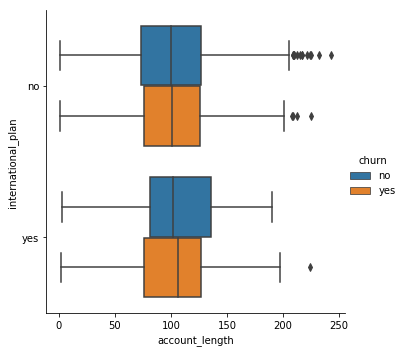

In [71]:
sns.catplot(x="account_length", y="international_plan", hue="churn", kind="box", data=df_pandas);


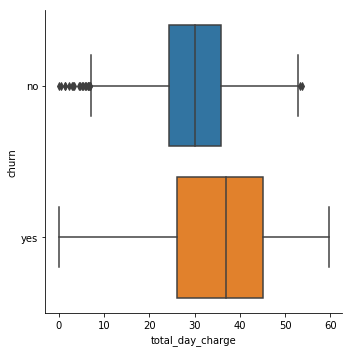

In [67]:
sns.catplot(x="total_day_charge", y="churn", kind="box", data=df_pandas);

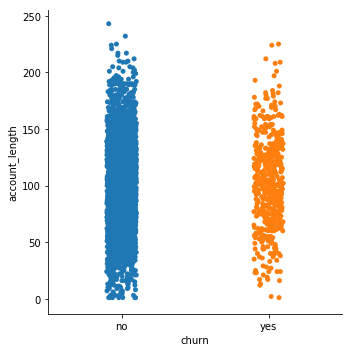

In [64]:
sns.catplot(x="churn", y="account_length", data=df_pandas);

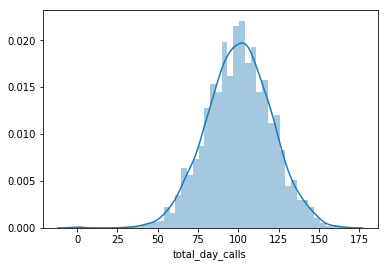

In [53]:
sns.distplot(df_pandas.total_day_calls)

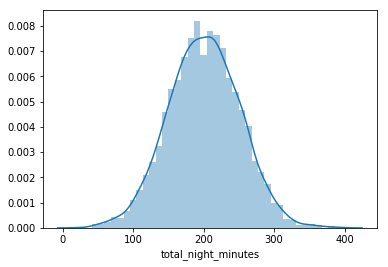

In [54]:
sns.distplot(df_pandas.total_night_minutes)

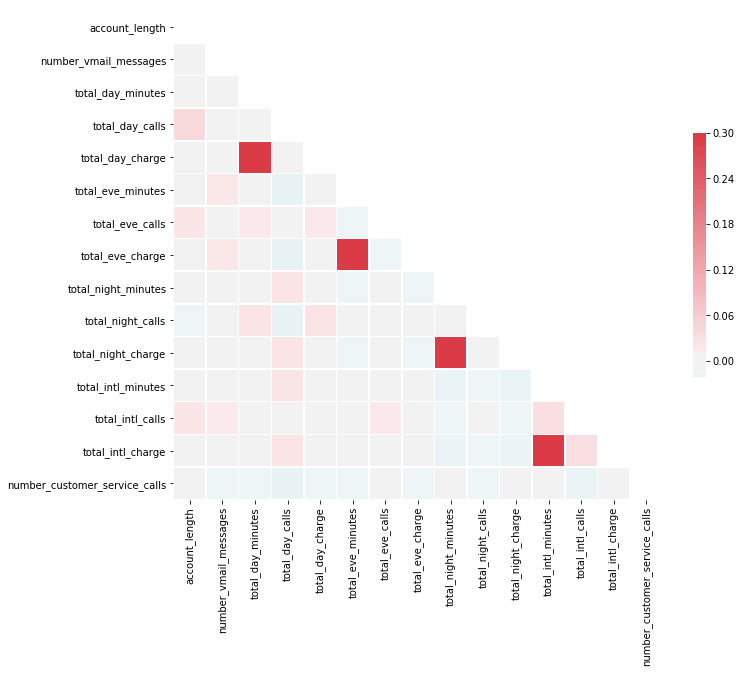

In [56]:
corr = df_pandas.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Correlation

In [32]:
from pyspark.mllib.stat import Statistics
import pandas as pd

num_cols_1 = ['account_length','number_vmail_messages','total_day_minutes','total_day_calls','total_day_charge']

num_cols_2 = ['total_eve_minutes','total_eve_calls','total_eve_charge','total_night_minutes', \
            'total_night_calls']
              
              
num_cols_3 = ['total_night_charge','total_intl_calls', \
            'total_intl_charge']          
              
df_corr = df[num_cols_1]
col_names = df_corr.columns

features = df_corr.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

print(corr_df.T.to_string())


                       account_length  number_vmail_messages  total_day_minutes  total_day_calls  total_day_charge
account_length               1.000000              -0.004628           0.006216         0.038470          0.006214
number_vmail_messages       -0.004628               1.000000           0.000778        -0.009548          0.000776
total_day_minutes            0.006216               0.000778           1.000000         0.006750          1.000000
total_day_calls              0.038470              -0.009548           0.006750         1.000000          0.006753
total_day_charge             0.006214               0.000776           1.000000         0.006753          1.000000


In [27]:
df_corr = df[num_cols_2]
col_names = df_corr.columns

features = df_corr.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

print(corr_df.T.to_string())

                     total_eve_minutes  total_eve_calls  total_eve_charge  total_night_minutes  total_night_calls
total_eve_minutes             1.000000        -0.011430          1.000000            -0.012584           0.007586
total_eve_calls              -0.011430         1.000000         -0.011423            -0.002093           0.007710
total_eve_charge              1.000000        -0.011423          1.000000            -0.012592           0.007596
total_night_minutes          -0.012584        -0.002093         -0.012592             1.000000           0.011204
total_night_calls             0.007586         0.007710          0.007596             0.011204           1.000000


In [33]:
df_corr = df[num_cols_3]
col_names = df_corr.columns

features = df_corr.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

print(corr_df.T.to_string())

                    total_night_charge  total_intl_calls  total_intl_charge
total_night_charge            1.000000         -0.012329          -0.015186
total_intl_calls             -0.012329          1.000000           0.032372
total_intl_charge            -0.015186          0.032372           1.000000


### Missing

In [34]:
for col in df.columns:
    print(col, '\t', 'with null values: ', df.filter(df[col].isNull()).count())

state 	 with null values:  0
account_length 	 with null values:  0
area_code 	 with null values:  0
international_plan 	 with null values:  0
voice_mail_plan 	 with null values:  0
number_vmail_messages 	 with null values:  0
total_day_minutes 	 with null values:  0
total_day_calls 	 with null values:  0
total_day_charge 	 with null values:  0
total_eve_minutes 	 with null values:  0
total_eve_calls 	 with null values:  0
total_eve_charge 	 with null values:  0
total_night_minutes 	 with null values:  0
total_night_calls 	 with null values:  0
total_night_charge 	 with null values:  0
total_intl_minutes 	 with null values:  0
total_intl_calls 	 with null values:  0
total_intl_charge 	 with null values:  0
number_customer_service_calls 	 with null values:  0
churn 	 with null values:  0


### Data Clean

In [36]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoderEstimator, OneHotEncoder
import numpy as np

In [37]:
cols = df.columns

cat_cols = ['state', 'area_code','international_plan','voice_mail_plan']

num_cols = ['account_length','number_vmail_messages','total_day_minutes','total_day_calls','total_day_charge', \
            'total_eve_minutes','total_eve_calls','total_eve_charge','total_night_minutes', \
            'total_night_calls','total_night_charge','total_intl_minutes','total_intl_calls', \
            'total_intl_charge','number_customer_service_calls']

In [38]:
stages = []

for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol+"_indexed")

    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], 
                                     outputCols=[categoricalCol + "_encoded"])
    stages += [stringIndexer, encoder]


label_stringIdx = StringIndexer(inputCol = 'churn', outputCol = 'churn_label')
stages += [label_stringIdx]


assemblerInputs = [c + "_encoded" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [39]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
model = pipelineModel.transform(df)

In [40]:
df_final = model.select('features', 'churn_label')
pd.DataFrame(df_final.take(5), columns=df_final.columns)

,features,churn_label
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.0
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.0
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0


In [41]:
train, valid = df_final.randomSplit([0.7, 0.3], seed = 2019)
print("Training Dataset Count: " + str(train.count()))
print("Validation Dataset Count: " + str(valid.count()))

Training Dataset Count: 2298
Validation Dataset Count: 1035


### LR

In [42]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="churn_label", featuresCol="features",maxIter=10)
model=lr.fit(train)
predict_train=model.transform(train)
predict_valid=model.transform(valid)


from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='churn_label')

predict_valid.select("churn_label","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_valid)))

+-----------+--------------------+----------+--------------------+
|churn_label|       rawPrediction|prediction|         probability|
+-----------+--------------------+----------+--------------------+
|        0.0|[5.68172933882108...|       0.0|[0.99660391236751...|
|        0.0|[3.28876935234644...|       0.0|[0.96404151749181...|
|        0.0|[2.61474325746299...|       0.0|[0.93180442431784...|
|        0.0|[2.97101587960170...|       0.0|[0.95124741080696...|
|        0.0|[1.80522580131630...|       0.0|[0.85878387863129...|
+-----------+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.8307465532414159
The area under ROC for test set is 0.7924661987563132


## GBT

In [43]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="churn_label", featuresCol="features", maxIter=10)


# Train model.  This also runs the indexers.
gbt_model = gbt.fit(train)

predict_train=gbt_model.transform(train)
predict_valid=gbt_model.transform(valid)


from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='churn_label')
predict_valid.select("churn_label","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_valid)))

+-----------+--------------------+----------+--------------------+
|churn_label|       rawPrediction|prediction|         probability|
+-----------+--------------------+----------+--------------------+
|        0.0|[1.24310974851698...|       0.0|[0.92317009123744...|
|        0.0|[1.24310974851698...|       0.0|[0.92317009123744...|
|        0.0|[1.22114784233916...|       0.0|[0.91999622050763...|
|        0.0|[1.24310974851698...|       0.0|[0.92317009123744...|
|        0.0|[1.24310974851698...|       0.0|[0.92317009123744...|
+-----------+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.9509782927544734
The area under ROC for test set is 0.9107163696380642
